<a href="https://colab.research.google.com/github/cw118/codeml2024/blob/main/air_canada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [400]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models

### Air Canada

In [401]:
baseline = pd.read_csv("baseline.csv")

baseline

,id,ticket_id,od,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
0,0,4157258036156055,BBBDDD,2024-01-01 03:00,2023-07-23 15:08,0,2,3,48,86,50,10,50,10,NaN
1,1,"7,18E+15",BBBDDD,2024-01-01 03:00,2023-07-26 11:44,1,2,1,37,82,50,10,50,7,NaN
2,5,3193079964098903,BBBDDD,2024-01-01 03:00,2023-08-29 10:30,0,0,1,50,100,50,10,50,4,NaN
3,6,7188323188824055,BBBDDD,2024-01-01 03:00,2023-09-09 17:14,0,1,2,34,71,50,10,50,4,NaN
4,9,8613619724770241,BBBDDD,2024-01-01 03:00,2023-09-29 10:01,0,3,3,40,85,50,10,48,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64162,256635,6215267925081839,AAABBB,2024-12-29 23:00,2024-12-14 06:47,0,1,1,40,78,250,50,202,1,NaN
64163,256643,1131175186978192,AAABBB,2024-12-29 23:00,2024-12-18 05:56,0,1,2,47,83,250,50,200,0,NaN
64164,256659,"7,81E+15",AAABBB,2024-12-29 23:00,2024-12-27 12:41,0,3,4,37,88,250,50,196,0,NaN
64165,256662,9563718482288973,AAABBB,2024-12-29 23:00,2024-12-28 06:04,0,0,2,43,78,250,50,189,0,NaN


In [402]:
participant = pd.read_csv("participant_data.csv")

participant

,id,ticket_id,od,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
0,0,4157258036156055,BBBDDD,2024-01-01 03:00,2023-07-23 15:08,0,2,3,48,86,50,10,50,10,NaN
1,1,"7,18E+15",BBBDDD,2024-01-01 03:00,2023-07-26 11:44,1,2,1,37,82,50,10,50,7,NaN
2,2,3353015593651433,BBBDDD,2024-01-01 03:00,2023-08-03 06:03,0,1,2,35,80,50,10,50,7,pref
3,3,5763957877920625,BBBDDD,2024-01-01 03:00,2023-08-13 17:41,0,3,1,36,68,50,10,50,5,nochoice
4,4,1095418927576125,BBBDDD,2024-01-01 03:00,2023-08-20 22:04,0,3,1,57,70,50,10,50,5,pref
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256660,256660,7797906628516656,AAABBB,2024-12-29 23:00,2024-12-27 13:43,1,2,1,47,69,250,50,192,0,advs
256661,256661,6321470299450035,AAABBB,2024-12-29 23:00,2024-12-27 17:45,0,3,2,42,73,250,50,191,0,advs
256662,256662,9563718482288973,AAABBB,2024-12-29 23:00,2024-12-28 06:04,0,0,2,43,78,250,50,189,0,NaN
256663,256663,5476766202516581,AAABBB,2024-12-29 23:00,2024-12-28 14:51,1,1,1,38,96,250,50,189,0,NaN


In [403]:
df = participant[participant['choice'].notna()]

df_pred = baseline.copy()

Train on participant data, predict on baseline data.

In [404]:
df = df.drop(columns=['ticket_id', 'od'])

In [405]:
df

,id,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
2,2,2024-01-01 03:00,2023-08-03 06:03,0,1,2,35,80,50,10,50,7,pref
3,3,2024-01-01 03:00,2023-08-13 17:41,0,3,1,36,68,50,10,50,5,nochoice
4,4,2024-01-01 03:00,2023-08-20 22:04,0,3,1,57,70,50,10,50,5,pref
7,7,2024-01-01 03:00,2023-09-17 22:16,1,3,1,41,76,50,10,48,4,pref
8,8,2024-01-01 03:00,2023-09-25 00:53,1,0,3,44,81,50,10,48,3,nochoice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256657,256657,2024-12-29 23:00,2024-12-27 04:30,0,0,3,41,59,250,50,196,0,nochoice
256658,256658,2024-12-29 23:00,2024-12-27 08:32,0,0,3,56,69,250,50,196,0,nochoice
256660,256660,2024-12-29 23:00,2024-12-27 13:43,1,2,1,47,69,250,50,192,0,advs
256661,256661,2024-12-29 23:00,2024-12-27 17:45,0,3,2,42,73,250,50,191,0,advs


Inventory probably not helpful, capacity (constant values) likely not either.

In [406]:
df.dtypes

id                            int64
flight_departure_datetime    object
purchase_datetime            object
trip_type                     int64
branded_fare                  int64
number_of_pax                 int64
ADVS_price                    int64
PREF_price                    int64
ADVS_capacity                 int64
PREF_capacity                 int64
ADVS_inventory                int64
PREF_inventory                int64
choice                       object
dtype: object

In [407]:
df = df.drop(columns=['ADVS_capacity', 'PREF_capacity'])

In [408]:
import matplotlib.pyplot as plt

Convert dates into timestamps (seconds or ms).

In [409]:
df['flight_departure_datetime'] = pd.to_datetime(df['flight_departure_datetime'])
df['flight_departure_datetime'] = df['flight_departure_datetime'].astype(np.int64) // 10**9 - 1704078000

df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])
df['purchase_datetime'] = df['purchase_datetime'].astype(np.int64) // 10**9 - 1691042580
df['purchase_datetime']

2                0
3           905880
4          1526460
7          3946380
8          4560600
            ...   
256657    44231220
256658    44245740
256660    44264400
256661    44278920
256664    44369820
Name: purchase_datetime, Length: 192498, dtype: int64

Scaling the timestamps

In [410]:
from sklearn.preprocessing import MinMaxScaler
df['flight_departure_datetime'] = MinMaxScaler().fit_transform(df[['flight_departure_datetime']])

from sklearn.preprocessing import MinMaxScaler
df['purchase_datetime'] = MinMaxScaler().fit_transform(df[['purchase_datetime']])
df['purchase_datetime']

2         0.048591
3         0.068015
4         0.081322
7         0.133212
8         0.146383
            ...   
256657    0.997028
256658    0.997339
256660    0.997740
256661    0.998051
256664    1.000000
Name: purchase_datetime, Length: 192498, dtype: float64

Turning choice into int (0=nochoice, 1=pref, 2=advs) and checking number of occurrences for each

In [411]:
df.loc[df["choice"] == "nochoice", "choice"] = 0
df.loc[df["choice"] == "pref", "choice"] = 1
df.loc[df["choice"] == "advs", "choice"] = 2

df = df.astype({'choice':'int64'})

print(df['choice'].value_counts())

df

choice
0    130886
2     33331
1     28281
Name: count, dtype: int64


,id,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_inventory,PREF_inventory,choice
2,2,0.0,0.048591,0,1,2,35,80,50,7,1
3,3,0.0,0.068015,0,3,1,36,68,50,5,0
4,4,0.0,0.081322,0,3,1,57,70,50,5,1
7,7,0.0,0.133212,1,3,1,41,76,48,4,1
8,8,0.0,0.146383,1,0,3,44,81,48,3,0
...,...,...,...,...,...,...,...,...,...,...,...
256657,256657,1.0,0.997028,0,0,3,41,59,196,0,0
256658,256658,1.0,0.997339,0,0,3,56,69,196,0,0
256660,256660,1.0,0.997740,1,2,1,47,69,192,0,2
256661,256661,1.0,0.998051,0,3,2,42,73,191,0,2


Normalizing some more columns (price, inventory)

In [412]:
df['ADVS_price'] = MinMaxScaler().fit_transform(df[['ADVS_price']])
df['PREF_price'] = MinMaxScaler().fit_transform(df[['PREF_price']])
df['ADVS_inventory'] = MinMaxScaler().fit_transform(df[['ADVS_inventory']])
df['PREF_inventory'] = MinMaxScaler().fit_transform(df[['PREF_inventory']])

df

,id,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_inventory,PREF_inventory,choice
2,2,0.0,0.048591,0,1,2,0.388889,0.401961,0.115044,0.14,1
3,3,0.0,0.068015,0,3,1,0.398148,0.284314,0.115044,0.10,0
4,4,0.0,0.081322,0,3,1,0.592593,0.303922,0.115044,0.10,1
7,7,0.0,0.133212,1,3,1,0.444444,0.362745,0.106195,0.08,1
8,8,0.0,0.146383,1,0,3,0.472222,0.411765,0.106195,0.06,0
...,...,...,...,...,...,...,...,...,...,...,...
256657,256657,1.0,0.997028,0,0,3,0.444444,0.196078,0.761062,0.00,0
256658,256658,1.0,0.997339,0,0,3,0.583333,0.294118,0.761062,0.00,0
256660,256660,1.0,0.997740,1,2,1,0.500000,0.294118,0.743363,0.00,2
256661,256661,1.0,0.998051,0,3,2,0.453704,0.333333,0.738938,0.00,2


Splitting dataset into test and train

In [413]:
list_columns = ['flight_departure_datetime', 'purchase_datetime', "trip_type", "branded_fare", "number_of_pax", "ADVS_price", "PREF_price", "ADVS_inventory", "PREF_inventory"]
choice = df["choice"].to_numpy()
inputs = df[list_columns].to_numpy()


less_columns = df[["trip_type", "branded_fare", "number_of_pax", "ADVS_price", "PREF_price"]].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(inputs, choice, test_size=0.2, random_state=0)

X_less, X_testless, y_less, y_testless = train_test_split(less_columns, choice, test_size=0.2, random_state=0)

print("xtrain=", X_train, "\nytrain=", y_train, "\n")
print("xtest=", X_test, "\nytest=", y_test)

xtrain= [[0.47778287 0.52828186 0.         ... 0.49019608 0.96017699 0.62      ]
 [0.77725607 0.57359073 0.         ... 0.58823529 0.38053097 0.6       ]
 [0.44434265 0.57856844 1.         ... 0.25490196 0.87168142 0.12      ]
 ...
 [0.61520843 0.4804925  1.         ... 0.3627451  1.         0.96      ]
 [0.90334402 0.9208391  1.         ... 0.3627451  0.76548673 0.        ]
 [0.22675218 0.36919969 0.         ... 0.57843137 0.33185841 0.38      ]] 
ytrain= [0 2 0 ... 0 2 0] 

xtest= [[0.93449382 0.88207239 0.         ... 0.60784314 0.10619469 0.08      ]
 [0.8236372  0.87014081 0.         ... 0.24509804 0.72566372 0.        ]
 [0.68621164 0.70223154 0.         ... 0.41176471 0.98672566 0.42      ]
 ...
 [0.87860742 0.91048355 0.         ... 0.29411765 0.78761062 0.        ]
 [0.60925332 0.72141805 0.         ... 0.46078431 0.83628319 0.        ]
 [0.3591388  0.52686664 0.         ... 0.43137255 0.82300885 0.02      ]] 
ytest= [0 2 0 ... 0 2 0]


Oversample the training set to make it more balanced between the 3 choices

In [414]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_testresampled, y_testresampled = ros.fit_resample(X_test, y_test)

from collections import Counter
print(sorted(Counter(y_resampled).items()))
print(sorted(Counter(y_testresampled).items()))

[(0, 104661), (1, 104661), (2, 104661)]
[(0, 26225), (1, 26225), (2, 26225)]


Sequential model

In [415]:
sequential = models.Sequential(
    [   
        layers.Dense(20, activation="relu"),
        layers.Dense(10,activation="relu"),
        layers.Flatten(),
        layers.Dense(3, activation="relu"),
        layers.Dense(3) #3 classes classficiation
    ]
)

sequential.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [416]:
sequential2 = models.Sequential(
    [   
        layers.Dense(20, activation="relu"),
        layers.Dense(10,activation="relu"),
        layers.Flatten(),
        layers.Dense(3, activation="relu"),
        layers.Dense(3) #3 classes classficiation
    ]
)

sequential2.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training the model

In [417]:
sequential.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

#history_less = sequential.fit(X_less, y_less, epochs=20,
#                    validation_data=(X_testless, y_testless))


history_normalized = sequential.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))

#history_oversampled = sequential.fit(X_resampled, y_resampled, epochs=10,
 #                   validation_data=(X_testresampled, y_testresampled))

Epoch 1/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 5s 793us/step - accuracy: 0.7107 - loss: 0.6923 - val_accuracy: 0.7341 - val_loss: 0.6393
Epoch 2/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 4s 796us/step - accuracy: 0.7335 - loss: 0.6353 - val_accuracy: 0.7373 - val_loss: 0.6313
Epoch 3/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 4s 784us/step - accuracy: 0.7347 - loss: 0.6300 - val_accuracy: 0.7381 - val_loss: 0.6300
Epoch 4/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 5s 991us/step - accuracy: 0.7380 - loss: 0.6239 - val_accuracy: 0.7409 - val_loss: 0.6240
Epoch 5/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 4s 884us/step - accuracy: 0.7373 - loss: 0.6247 - val_accuracy: 0.7400 - val_loss: 0.6209
Epoch 6/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 5s 989us/step - accuracy: 0.7409 - loss: 0.6179 - val_accuracy: 0.7429 - val_loss: 0.6185
Epoch 7/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7403 - loss: 0.6152 - val_accuracy: 0.7426 - val_loss: 0.6157
Epoch 8/10
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7381 - los

In [418]:
sequential2.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])


history_oversampled = sequential2.fit(X_resampled, y_resampled, epochs=10,
                    validation_data=(X_testresampled, y_testresampled))

Epoch 1/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.5090 - loss: 0.9527 - val_accuracy: 0.5651 - val_loss: 0.8844
Epoch 2/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5662 - loss: 0.8736 - val_accuracy: 0.5684 - val_loss: 0.8766
Epoch 3/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.5701 - loss: 0.8709 - val_accuracy: 0.5697 - val_loss: 0.8773
Epoch 4/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5738 - loss: 0.8685 - val_accuracy: 0.5811 - val_loss: 0.8686
Epoch 5/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 10s 991us/step - accuracy: 0.5796 - loss: 0.8634 - val_accuracy: 0.5740 - val_loss: 0.8720
Epoch 6/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5858 - loss: 0.8618 - val_accuracy: 0.5869 - val_loss: 0.8626
Epoch 7/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.5944 - loss: 0.8521 - val_accuracy: 0.6212 - val_loss: 0.8118
Epoch 8/10
9812/9812 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6212 - loss:

Evaluate the model

In [419]:
"""
print("Normalized, less columns model")
plt.plot(history_less.history["accuracy"], label="Training accuracy")
plt.plot(history_less.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

test_loss, test_accuracy = sequential.evaluate(X_less, y_less, verbose=2)

print(f"Accuracy of model = {test_accuracy:.4f}")
print(f"Test loss of model = {test_loss:.4f}")
"""

'\nprint("Normalized, less columns model")\nplt.plot(history_less.history["accuracy"], label="Training accuracy")\nplt.plot(history_less.history["val_accuracy"], label="Validation accuracy")\nplt.xlabel("Epoch")\nplt.ylabel("Accuracy")\nplt.legend(loc="lower right")\n\ntest_loss, test_accuracy = sequential.evaluate(X_less, y_less, verbose=2)\n\nprint(f"Accuracy of model = {test_accuracy:.4f}")\nprint(f"Test loss of model = {test_loss:.4f}")\n'

Normalized, non oversampled model
4813/4813 - 4s - 769us/step - accuracy: 0.7426 - loss: 0.6071
Accuracy of model = 0.7426
Test loss of model = 0.6071


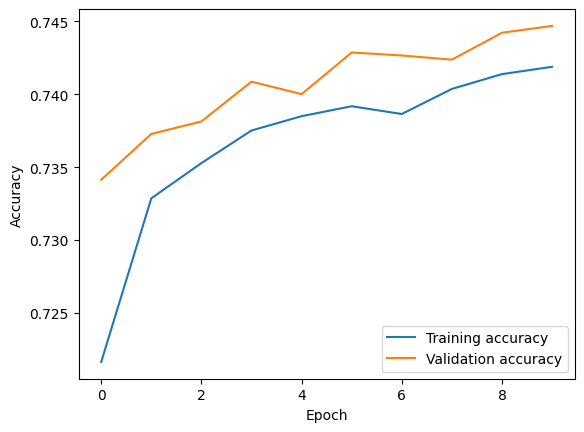

In [420]:
print("Normalized, non oversampled model")
plt.plot(history_normalized.history["accuracy"], label="Training accuracy")
plt.plot(history_normalized.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

test_loss, test_accuracy = sequential.evaluate(X_train, y_train, verbose=2)

print(f"Accuracy of model = {test_accuracy:.4f}")
print(f"Test loss of model = {test_loss:.4f}")

Normalized, oversampled model
9812/9812 - 8s - 831us/step - accuracy: 0.5430 - loss: 0.9642
Accuracy of model = 0.5430
Test loss of model = 0.9642


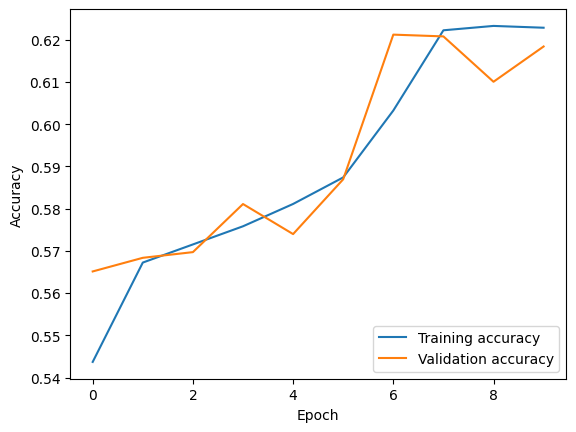

In [421]:
print("Normalized, oversampled model")
plt.plot(history_oversampled.history["accuracy"], label="Training accuracy")
plt.plot(history_oversampled.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

test_loss, test_accuracy = sequential.evaluate(X_resampled, y_resampled, verbose=2)

print(f"Accuracy of model = {test_accuracy:.4f}")
print(f"Test loss of model = {test_loss:.4f}")

KNN classifier

In [436]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, weights="uniform")
knn.fit(X_resampled, y_resampled)

print(knn.score(X_testresampled, y_testresampled))


0.5501366380680013


RF classfier

In [450]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=6, max_leaf_nodes=6, max_features="log2")
clf = clf.fit(X_resampled, y_resampled)

print(clf.score(X_test, y_test))

0.6508571428571429


# Predict for baseline: prepare the data

In [424]:
df_pred

,id,ticket_id,od,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
0,0,4157258036156055,BBBDDD,2024-01-01 03:00,2023-07-23 15:08,0,2,3,48,86,50,10,50,10,NaN
1,1,"7,18E+15",BBBDDD,2024-01-01 03:00,2023-07-26 11:44,1,2,1,37,82,50,10,50,7,NaN
2,5,3193079964098903,BBBDDD,2024-01-01 03:00,2023-08-29 10:30,0,0,1,50,100,50,10,50,4,NaN
3,6,7188323188824055,BBBDDD,2024-01-01 03:00,2023-09-09 17:14,0,1,2,34,71,50,10,50,4,NaN
4,9,8613619724770241,BBBDDD,2024-01-01 03:00,2023-09-29 10:01,0,3,3,40,85,50,10,48,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64162,256635,6215267925081839,AAABBB,2024-12-29 23:00,2024-12-14 06:47,0,1,1,40,78,250,50,202,1,NaN
64163,256643,1131175186978192,AAABBB,2024-12-29 23:00,2024-12-18 05:56,0,1,2,47,83,250,50,200,0,NaN
64164,256659,"7,81E+15",AAABBB,2024-12-29 23:00,2024-12-27 12:41,0,3,4,37,88,250,50,196,0,NaN
64165,256662,9563718482288973,AAABBB,2024-12-29 23:00,2024-12-28 06:04,0,0,2,43,78,250,50,189,0,NaN


In [425]:
df_pred['ADVS_price'] = MinMaxScaler().fit_transform(df_pred[['ADVS_price']])
df_pred['PREF_price'] = MinMaxScaler().fit_transform(df_pred[['PREF_price']])

df_pred['flight_departure_datetime'] = pd.to_datetime(df_pred['flight_departure_datetime'])
df_pred['flight_departure_datetime'] = df_pred['flight_departure_datetime'].astype(np.int64) // 10**9 - 1704078000

df_pred['purchase_datetime'] = pd.to_datetime(df_pred['purchase_datetime'])
df_pred['purchase_datetime'] = df_pred['purchase_datetime'].astype(np.int64) // 10**9 - 1691042580

df_pred['flight_departure_datetime'] = MinMaxScaler().fit_transform(df_pred[['flight_departure_datetime']])
df_pred['purchase_datetime'] = MinMaxScaler().fit_transform(df_pred[['purchase_datetime']])

list_columns = ['flight_departure_datetime', 'purchase_datetime', "trip_type", "branded_fare", "number_of_pax", "ADVS_price", "PREF_price", "ADVS_inventory", "PREF_inventory"]
inputs_pred = df_pred[list_columns].to_numpy()

print(inputs_pred)
df_pred[list_columns]

[[0.00000000e+00 3.03452191e-02 0.00000000e+00 ... 4.69387755e-01
  5.00000000e+01 1.00000000e+01]
 [0.00000000e+00 3.56315831e-02 1.00000000e+00 ... 4.28571429e-01
  5.00000000e+01 7.00000000e+00]
 [0.00000000e+00 9.84180723e-02 0.00000000e+00 ... 6.12244898e-01
  5.00000000e+01 4.00000000e+00]
 ...
 [1.00000000e+00 9.97422320e-01 0.00000000e+00 ... 4.89795918e-01
  1.96000000e+02 0.00000000e+00]
 [1.00000000e+00 9.98761891e-01 0.00000000e+00 ... 3.87755102e-01
  1.89000000e+02 0.00000000e+00]
 [1.00000000e+00 9.99438741e-01 1.00000000e+00 ... 5.71428571e-01
  1.89000000e+02 0.00000000e+00]]


,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_inventory,PREF_inventory
0,0.0,0.030345,0,2,3,0.510417,0.469388,50,10
1,0.0,0.035632,1,2,1,0.395833,0.428571,50,7
2,0.0,0.098418,0,0,1,0.531250,0.612245,50,4
3,0.0,0.119281,0,1,2,0.364583,0.316327,50,4
4,0.0,0.155714,0,3,3,0.427083,0.459184,48,3
...,...,...,...,...,...,...,...,...,...
64162,1.0,0.972925,0,1,1,0.427083,0.387755,202,1
64163,1.0,0.980257,0,1,2,0.500000,0.438776,200,0
64164,1.0,0.997422,0,3,4,0.395833,0.489796,196,0
64165,1.0,0.998762,0,0,2,0.458333,0.387755,189,0


In [426]:
results = sequential.predict(inputs_pred)
print(results)
results = np.argmax(results, 1)

results

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step
[[-17.674652     1.9061124   -0.443363  ]
 [-15.940703     1.7922136   -0.43632686]
 [-12.603202     1.3833317   -0.63243186]
 ...
 [-39.004745     3.3072348   -0.5299177 ]
 [-37.466164     3.2061691   -0.52367437]
 [-37.971798     3.2393827   -0.52572614]]


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [427]:
results2 = sequential2.predict(inputs_pred)
print(results2)
results2 = np.argmax(results2, 1)

results2

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step
[[-31.99977    29.206808   -6.469664 ]
 [-32.838215   27.808233   -4.0667343]
 [-31.52844    25.29656    -2.2834451]
 ...
 [-96.68188    77.687096   -5.4560475]
 [-92.38519    73.479774   -4.359865 ]
 [-93.624344   75.24554    -5.3272433]]


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [451]:
results3 = clf.predict(inputs_pred)
results3

array([1, 1, 0, ..., 2, 0, 2], dtype=int64)

In [446]:
results4 = knn.predict(inputs_pred)
results4

array([1, 1, 0, ..., 2, 1, 1], dtype=int64)

In [452]:

results_choices = pd.DataFrame(results, columns=["choice"])
results_choices = results_choices.astype({'choice':'object'})

results_choices.loc[results_choices["choice"] == 0, "choice"] = "nochoice"
results_choices.loc[results_choices["choice"] == 1, "choice"] = "pref"
results_choices.loc[results_choices["choice"] == 2, "choice"] = "advs"


results_choices2 = pd.DataFrame(results2, columns=["choice"])
results_choices2 = results_choices2.astype({'choice':'object'})

results_choices2.loc[results_choices2["choice"] == 0, "choice"] = "nochoice"
results_choices2.loc[results_choices2["choice"] == 1, "choice"] = "pref"
results_choices2.loc[results_choices2["choice"] == 2, "choice"] = "advs"


results_choices3 = pd.DataFrame(results3, columns=["choice"])
results_choices3 = results_choices3.astype({'choice':'object'})

results_choices3.loc[results_choices3["choice"] == 0, "choice"] = "nochoice"
results_choices3.loc[results_choices3["choice"] == 1, "choice"] = "pref"
results_choices3.loc[results_choices3["choice"] == 2, "choice"] = "advs"

results_choices4 = pd.DataFrame(results4, columns=["choice"])
results_choices4 = results_choices4.astype({'choice':'object'})

results_choices4.loc[results_choices4["choice"] == 0, "choice"] = "nochoice"
results_choices4.loc[results_choices4["choice"] == 1, "choice"] = "pref"
results_choices4.loc[results_choices4["choice"] == 2, "choice"] = "advs"

results_choices3

,choice
0,pref
1,pref
2,nochoice
3,advs
4,pref
...,...
64162,advs
64163,nochoice
64164,advs
64165,nochoice


In [453]:
print(baseline)
#baseline.pop("choice")

final = pd.concat([baseline, results_choices], axis=1)

final2 = pd.concat([baseline, results_choices2], axis=1)

final3 = pd.concat([baseline, results_choices3], axis=1)

final4 = pd.concat([baseline, results_choices4], axis=1)

           id         ticket_id      od flight_departure_datetime  \
0           0  4157258036156055  BBBDDD          2024-01-01 03:00   
1           1          7,18E+15  BBBDDD          2024-01-01 03:00   
2           5  3193079964098903  BBBDDD          2024-01-01 03:00   
3           6  7188323188824055  BBBDDD          2024-01-01 03:00   
4           9  8613619724770241  BBBDDD          2024-01-01 03:00   
...       ...               ...     ...                       ...   
64162  256635  6215267925081839  AAABBB          2024-12-29 23:00   
64163  256643  1131175186978192  AAABBB          2024-12-29 23:00   
64164  256659          7,81E+15  AAABBB          2024-12-29 23:00   
64165  256662  9563718482288973  AAABBB          2024-12-29 23:00   
64166  256663  5476766202516581  AAABBB          2024-12-29 23:00   

      purchase_datetime  trip_type  branded_fare  number_of_pax  ADVS_price  \
0      2023-07-23 15:08          0             2              3          48   
1      2023-0

In [454]:
final.to_csv("predictions.csv")

final2.to_csv("predictions2.csv")

final3.to_csv("RF.csv")

final4.to_csv("KNN.csv")
